<a href="https://colab.research.google.com/github/rachelyayra/Fire-segmentation-with-FCN/blob/main/Fire_Segmentation_FCN_32(VGG).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Fire Segmentation with Fully Convolutional networks

- This notebook implements FCN-32, an architecture usually used for image segmentation
- This implementation uses the transfer learning method to improve the preformance on the former FCN-32 without transfer learning.

Table of Contents:

1. Data Preprocessing
2. Model Building and Training
4. Tests
5. Evaluation
2. Save Model



### 1. Data Preprocessing

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"racheladjoe","key":"29f5e91018af6dd4a059fa0d341c1206"}'}

In [4]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets list

ref                                                                   title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/countries-of-the-world-2023                          Global Country Information Dataset 2023             23KB  2023-07-08 20:37:33          11092        439  1.0              
nelgiriyewithana/global-youtube-statistics-2023                       Global YouTube Statistics 2023                      60KB  2023-07-28 15:36:38           3210        124  1.0              
joebeachcapital/global-earth-temperatures                             Global Earth Temperatures                           33KB  2023-08-09 06:21:51            666         29  1.0              
joebeachcapital/top-500-hollywood-m

In [8]:
!kaggle datasets download -d diversisai/fire-segmentation-image-dataset

fire-segmentation-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
!unzip fire-segmentation-image-dataset.zip

Archive:  fire-segmentation-image-dataset.zip
replace Image/Fire/Img_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N



 IMPORT RELEVANT PACKAGES

In [15]:
import os
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling
from PIL import Image
from sklearn.model_selection import train_test_split


In [16]:
# Ground Truth Folder Path
gt_file_path = '/content/Segmentation_Mask/Fire'
# Image Folder Path
im_file_path = '/content/Image/Fire'

In [17]:
classes = os.listdir(gt_file_path)

In [18]:
clas = os.listdir(im_file_path)

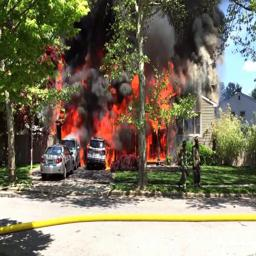

In [19]:
# Sample Images and
Image.open(os.path.join(im_file_path, classes[0]))

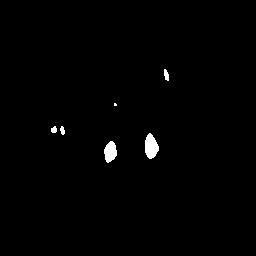

In [20]:
Image.open(os.path.join(gt_file_path, classes[0]))

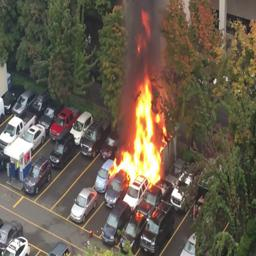

In [21]:
Image.open(os.path.join(im_file_path, classes[1]))

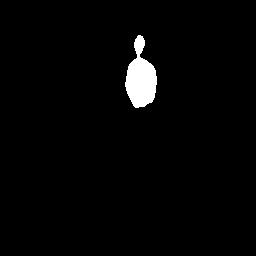

In [22]:
Image.open(os.path.join(gt_file_path, classes[1]))

CREATE TRAINING DATASET

In [23]:
def create_dataset_IM(img_folder):
    img_data_array=[]
    for dir1 in os.listdir(img_folder):
      if (len(img_data_array) == 2000):
        break
      image_path= os.path.join(img_folder, dir1)
      image= np.array(Image.open(image_path))
      # image =np.array(image).reshape(-1, 512, 512, 1)
      image = image.astype('float32')
      image /= 255
      img_data_array.append(image)
    return img_data_array


In [24]:
def create_dataset_GT(img_folder):
    img_data_array=[]
    for dir1 in os.listdir(img_folder):
      if (len(img_data_array) == 2000):
        break
      image_path= os.path.join(img_folder, dir1)
      image= np.array(Image.open(image_path))
            # image =np.array(image).reshape(-1, 512, 512, 1)
      image = image.astype('float32')
      image /= 255
      img_data_array.append(image)
    return img_data_array


In [25]:
groundTruth = create_dataset_GT(gt_file_path)

In [26]:
imageTruth = create_dataset_IM(im_file_path)

In [27]:
len(groundTruth)

2000

In [28]:
# Information on Images
imageTruth
dim1 = len(imageTruth)
dim2 = len(imageTruth[0])
dim3 = len(imageTruth[0][0])
dim4 = len(imageTruth[0][0][0])

print(dim1,dim2, dim3, dim4)

2000 256 256 3


In [29]:
# Reshaping Images
X =np.array(imageTruth).reshape(-1, 256, 256, 3)

In [30]:
y=np.array(groundTruth).reshape(-1, 256, 256, 1)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [32]:
y[0].shape

(256, 256, 1)

### 2. Model Building and Training

In [33]:
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.layers import  Activation, Flatten, Dense, Conv2D,  Conv2DTranspose, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.metrics import IoU
import tensorflow as tf
import pickle

In [34]:
# ADDING THE UPSAMPLING LAYER TO THE VGG MODEL

In [35]:
vgg = VGG16( input_shape= (256,256,3), weights='imagenet', include_top=False)

def createFCN():
  for layer in vgg.layers:
    layer.trainable = False
  # x = Conv2D(2,(2,2), padding='same')(vgg.output)
  # y = Conv2D(2,(2,2), padding='same')(x)
  # z = Conv2DTranspose( 1 ,(1,1), (32,32), activation = 'sigmoid')(y)
  # model = Model(vgg.input, z)
  x = Conv2D(2,(2,2), padding='same')(vgg.output)
  y = Conv2D(2,(2,2), padding='same')(x)
  z = UpSampling2D((32,32), interpolation = 'bilinear')(y)
  k = Conv2D(1,(2,2), padding='same', activation = 'sigmoid')(z)
  model = Model(vgg.input, k)

  model.compile(
  optimizer= Adam(learning_rate = 0.01),
  loss= 'binary_crossentropy',
  metrics=['accuracy'],
  )
  return model

In [36]:
fcn = createFCN()

In [37]:
fcn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [38]:
num_epochs = 50
history = fcn.fit(
    X_train,y_train, epochs = num_epochs, batch_size = 64, validation_split= 0.3
    )


Epoch 1/50
15/15 [==============================] - 45s 2s/step - loss: 0.3003 - accuracy: 0.9558 - val_loss: 0.1941 - val_accuracy: 0.9666
Epoch 2/50
15/15 [==============================] - 8s 527ms/step - loss: 0.1307 - accuracy: 0.9728 - val_loss: 0.0890 - val_accuracy: 0.9758
Epoch 3/50
15/15 [==============================] - 8s 533ms/step - loss: 0.0903 - accuracy: 0.9733 - val_loss: 0.0803 - val_accuracy: 0.9758
Epoch 4/50
15/15 [==============================] - 8s 523ms/step - loss: 0.0855 - accuracy: 0.9733 - val_loss: 0.0771 - val_accuracy: 0.9758
Epoch 5/50
15/15 [==============================] - 7s 496ms/step - loss: 0.0821 - accuracy: 0.9734 - val_loss: 0.0744 - val_accuracy: 0.9757
Epoch 6/50
15/15 [==============================] - 8s 515ms/step - loss: 0.0796 - accuracy: 0.9734 - val_loss: 0.0722 - val_accuracy: 0.9757
Epoch 7/50
15/15 [==============================] - 8s 524ms/step - loss: 0.0772 - accuracy: 0.9734 - val_loss: 0.0713 - val_accuracy: 0.9752
Epoch 8/

### 3. Tests

In [39]:
def test_image(image):
  test = image.reshape(-1,256,256,3)
  prediction = fcn.predict(test)
  pred = prediction.reshape(256,256)
  real_pred = (pred > 0.3).astype(int)
  return pred , real_pred

In [46]:
def real_test(image):
  test = image.reshape(-1,256,256,3)
  prediction = fcn.predict(test)
  pred = prediction.reshape(256,256)
  real_pred = (pred > 0.2).astype(int)
  return real_pred

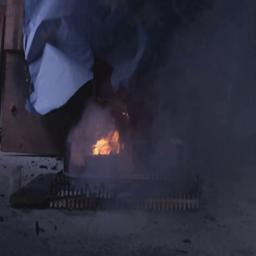

In [47]:
Image.fromarray((X_test[0]* 255).astype(np.uint8))

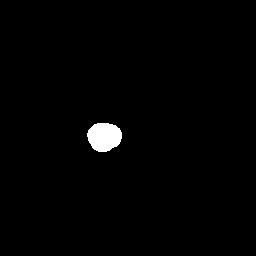

In [48]:
Image.fromarray((y_test[0].reshape(256,256)*255).astype(np.uint8))

In [49]:
# Test Image 1
raw1, real1 = test_image(X_test[0])

1/1 [==============================] - 0s 38ms/step


RAW PREDICTION

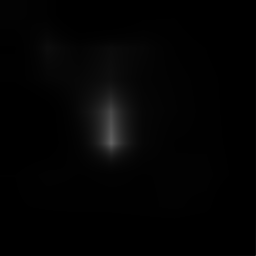

In [50]:
Image.fromarray((raw1* 255).astype(np.uint8))

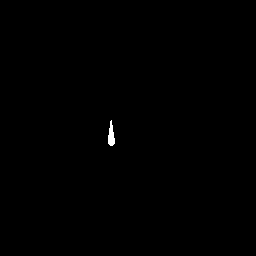

In [51]:
Image.fromarray((real1* 255).astype(np.uint8))

FINAL PREDICTION

### 4. Evaluation

In [52]:
import tensorflow as tf

# Create a MeanIoU object
iou_metric = tf.keras.metrics.MeanIoU(num_classes=2)  # 2 classes: background and region of interest

# Update the metric with the masks
iou_metric.update_state(y_test[0], real1)

# Calculate and print the IoU metric
iou_value = iou_metric.result().numpy()
print("IoU:", iou_value)

IoU: 0.578527


In [53]:
predicted_masks = [real_test(i) for i in X_test]

1/1 [==============================] - 0s 28ms/step


In [54]:
predicted_masks

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
   

In [55]:
len(y_test)

660

In [56]:
len(predicted_masks)

660

In [57]:
for predicted_mask, ground_truth_mask in zip(predicted_masks, y_test):
    # Convert masks to integer values (0 or 1)
    predicted_mask = tf.constant(predicted_mask, dtype=tf.int32)
    ground_truth_mask = tf.constant(ground_truth_mask, dtype=tf.int32)

    # Update the metric with the masks
    iou_metric.update_state(ground_truth_mask, predicted_mask)

# Calculate and print the mean IoU metric for all masks
mean_iou_value = iou_metric.result().numpy()
print("Mean IoU:", mean_iou_value)

Mean IoU: 0.5796353


### 5. Save Model

In [59]:
filename = '/content/drive/MyDrive/FCN-MODELS/FCN32-transfer.sav'
pickle.dump(fcn, open(filename, 'wb'))